In [1]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from joblib import dump, load

In [2]:
# ------------------------------
# 1. 设置随机种子（训练阶段已使用过 42，
#    这里只为了完整性保留）
# ------------------------------
def set_seed(seed: int):
    """
    Sets the random seed for Python, NumPy, and PyTorch to ensure reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
# ------------------------------
# 2. 定义 ResNet 模型结构（必须与训练时一致）
# ------------------------------
class ResNetBlock(nn.Module):
    def __init__(self, in_features: int):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, in_features)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_features, in_features)

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, in_features: int, num_blocks: int, hidden_size: int):
        super(ResNet, self).__init__()
        self.fc_in = nn.Linear(in_features, hidden_size)
        self.relu = nn.ReLU()
        self.blocks = nn.Sequential(
            *[ResNetBlock(hidden_size) for _ in range(num_blocks)]
        )
        self.fc_out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc_in(x)
        out = self.relu(out)
        out = self.blocks(out)
        out = self.fc_out(out)
        return out

In [4]:
# ========================================
# 3. 准备所有 set_point 及对应的最优超参数
# ========================================
set_points = [0.1, 0.2, 0.4, 0.8, 1.0]

# 最优超参数字典：键为 set_point，值为一个 dict，包含 batch_size, hidden_size, learning_rate, num_blocks
best_hyperparams = {
    0.1: {'batch_size': 32, 'hidden_size': 1024, 'learning_rate': 0.0006745429280232345, 'num_blocks': 10},
    0.2: {'batch_size': 16, 'hidden_size': 1024, 'learning_rate': 0.0006835482048243496, 'num_blocks': 19},
    0.4: {'batch_size': 16, 'hidden_size': 1024, 'learning_rate': 0.00015338750984788884, 'num_blocks': 13},
    0.8: {'batch_size': 16, 'hidden_size': 1024, 'learning_rate': 0.0005905078695008092, 'num_blocks': 20},
    1.0: {'batch_size': 16, 'hidden_size': 1024, 'learning_rate': 0.0004843728239154431, 'num_blocks': 11},
}

# ========================================
# 4. 定义文件路径和特征列
# ========================================
features = ['Temperature', 'RH', 'Bulk_DP', 'Num_Conc', 'OA', 'SO4', 'Cl', 'NH4', 'NO3']
partmc_train_data    = '/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/data/partmc_train.csv'
partmc_valid_data    = '/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/data/partmc_valid.csv'
partmc_test_data     = '/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/data/partmc_test.csv'
arm_data             = '/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/data/setpoint_{:.1f}.csv'  # 用于后续绘图
scaler_path          = '/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/scaler_X.pkl'  # 保存/加载 StandardScaler 的路径
device               = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
# ========================================
# 5. 先准备训练/验证/测试集，并保存 scaler
#    （只做一次，全 set_point 共享同一个特征标准化）
# ========================================
# 5.1 读取训练、验证、测试 CSV
train_df = pd.read_csv(partmc_train_data)
valid_df = pd.read_csv(partmc_valid_data)
test_df  = pd.read_csv(partmc_test_data)

# 5.2 将训练集的 X 做标准化，并保存 scaler
X_train_raw = train_df[features].values
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_raw)

# 存储 scaler，以便后面绘图时加载
dump(scaler_X, scaler_path)

# 5.3 验证集 & 测试集 同样按训练集的参数做 transform
X_valid_scaled = scaler_X.transform(valid_df[features].values)
X_test_scaled  = scaler_X.transform(test_df[features].values)

# 5.4 转为 PyTorch Tensor 并搬到 GPU（如可用）
X_valid_tensor = torch.tensor(X_valid_scaled, dtype=torch.float32).to(device)
X_test_tensor  = torch.tensor(X_test_scaled,  dtype=torch.float32).to(device)

# 后续需要从 train/valid/test DF 中取出不同 set_point 的 y 列
# 所以这里不再提前转为 tensor


In [6]:
# ========================================
# 6. 对于每个 set_point，训练并保存模型
# ========================================
num_epochs = 30
criterion = nn.MSELoss()

for sp in set_points:
    # 6.1 取出对应超参数
    hp = best_hyperparams[sp]
    batch_size     = hp['batch_size']
    hidden_size    = hp['hidden_size']
    learning_rate  = hp['learning_rate']
    num_blocks     = hp['num_blocks']

    # 6.2 定义标签列名
    ccn_col = f'CCN_VS_{sp}'

    # 6.3 提取 train/valid 的 X 和 y
    y_train_raw = train_df[ccn_col].values
    y_valid_raw = valid_df[ccn_col].values

    # 6.4 标准化后的 X 转为 tensor
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_raw, dtype=torch.float32).to(device)
    X_valid_tensor = torch.tensor(X_valid_scaled, dtype=torch.float32).to(device)
    y_valid_tensor = torch.tensor(y_valid_raw, dtype=torch.float32).to(device)

    # 6.5 创建 DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # 6.6 初始化模型、优化器
    input_size = len(features)
    model = ResNet(in_features=input_size, num_blocks=num_blocks, hidden_size=hidden_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 6.7 训练循环（30 个 epoch），并在验证集上选出最优模型
    best_val_loss = float('inf')
    best_state   = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch).view(-1)
            loss  = criterion(preds, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)

        # 验证阶段
        model.eval()
        with torch.no_grad():
            val_preds = model(X_valid_tensor).view(-1)
            val_loss  = criterion(val_preds, y_valid_tensor).item()

        # 保存最优模型权重
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()

        print(f"[set_point={sp}] Epoch {epoch+1:02d}/{num_epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # 6.8 训练完成后，载入验证集表现最好的模型，并保存到磁盘
    model.load_state_dict(best_state)
    torch.save(model.state_dict(), f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/Foundation_Model_{sp}.pth')
    print(f"→ Saved best model for set_point={sp} to Foundation_Model_{sp}.pth\n")

[set_point=0.1] Epoch 01/30, Train Loss: 28190.8830, Val Loss: 22806.1406
[set_point=0.1] Epoch 02/30, Train Loss: 14803.3396, Val Loss: 18143.5820
[set_point=0.1] Epoch 03/30, Train Loss: 8677.5429, Val Loss: 11532.8965
[set_point=0.1] Epoch 04/30, Train Loss: 6275.6814, Val Loss: 12161.9912
[set_point=0.1] Epoch 05/30, Train Loss: 5334.9862, Val Loss: 8484.5254
[set_point=0.1] Epoch 06/30, Train Loss: 4601.2152, Val Loss: 11350.5137
[set_point=0.1] Epoch 07/30, Train Loss: 4090.4724, Val Loss: 9562.7520
[set_point=0.1] Epoch 08/30, Train Loss: 3482.1019, Val Loss: 10120.9434
[set_point=0.1] Epoch 09/30, Train Loss: 3184.2636, Val Loss: 9503.7754
[set_point=0.1] Epoch 10/30, Train Loss: 2982.4496, Val Loss: 9841.7627
[set_point=0.1] Epoch 11/30, Train Loss: 2782.7194, Val Loss: 8556.5879
[set_point=0.1] Epoch 12/30, Train Loss: 2364.5092, Val Loss: 10029.6572
[set_point=0.1] Epoch 13/30, Train Loss: 2430.0857, Val Loss: 8668.7734
[set_point=0.1] Epoch 14/30, Train Loss: 2164.1438, Val

/tmp/ipykernel_34597/3905223083.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])  # Adjust layout to avoid overlap


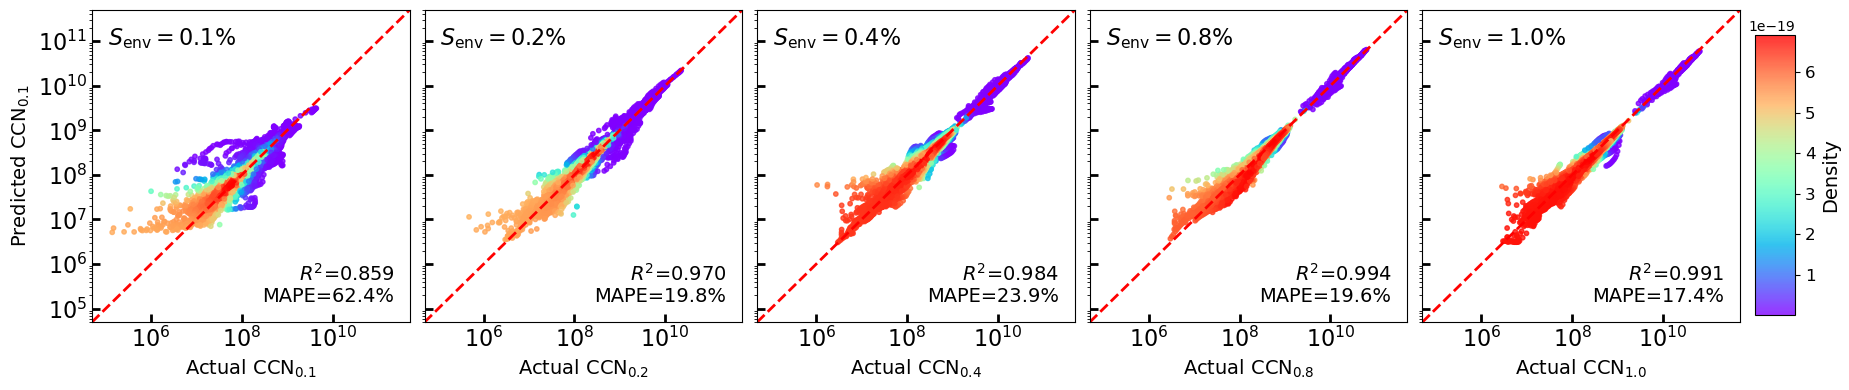

In [7]:
scaler_X = load(scaler_path)

xmin, xmax = 5e4, 5e11
ymin, ymax = 5e4, 5e11

fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)
scatter_list = []

for i, sp in enumerate(set_points):
    hp          = best_hyperparams[sp]
    hidden_size = hp['hidden_size']
    num_blocks  = hp['num_blocks']

    model = ResNet(in_features=len(features), num_blocks=num_blocks, hidden_size=hidden_size)
    model.load_state_dict(torch.load(f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/Foundation_Model_{sp}.pth', map_location=device))
    model.to(device)
    model.eval()

    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor).view(-1)

    y_pred_cpu = y_pred_tensor.cpu().numpy() * 1e6
    y_true_cpu = test_df[f'CCN_VS_{sp}'].values * 1e6

    # 计算 R²
    mse_val = mean_squared_error(y_true_cpu, y_pred_cpu)
    var_true = np.var(y_true_cpu)
    r2 = 1 - mse_val / var_true

    # 计算 MAPE （若真实值中有 0，需要过滤掉）
    nonzero_mask = y_true_cpu != 0
    mape = np.mean(np.abs((y_pred_cpu[nonzero_mask] - y_true_cpu[nonzero_mask]) / y_true_cpu[nonzero_mask])) * 100


    xy = np.vstack([y_true_cpu, y_pred_cpu])
    z  = gaussian_kde(xy)(xy)

    ax = axes[i]
    sc = ax.scatter(
        y_true_cpu, y_pred_cpu,
        c=z, s=10, cmap='rainbow', alpha=0.8
    )
    scatter_list.append(sc)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.plot([xmin, xmax], [xmin, xmax], 'r--', linewidth=2)

    # 用 text 在左上角标注 $S_{env}={sp}$
    ax.text(
        0.05, 0.95,
        f'$S_{{\\mathrm{{env}}}}={sp}\%$',
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment='top'
    )
    # 右下角：添加 R² 和 MAPE
    ax.text(
        0.95, 0.05,
        f'$R^2$={r2:.3f}\nMAPE={mape:.1f}%',
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='bottom',
        horizontalalignment='right'
    )

    ax.set_xlabel(f'Actual CCN$_{{{sp}}}$', fontsize=14)
    if i == 0:
        ax.set_ylabel(f'Predicted CCN$_{{{sp}}}$', fontsize=14)
    # ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='major', direction='in', length=6, width=2, colors='black',
                    grid_color='gray', grid_alpha=0.7, labelsize=16)

# ----------------------------------------
# 7.1 在最右侧再创建一个专门的轴，用于放 colorbar
# ----------------------------------------
fig.subplots_adjust(right=0.88)  # Shrink figure a bit to make space for colorbar
cbar_ax = fig.add_axes([0.88, 0.20, 0.02, 0.7])   # [left, bottom, width, height]
cbar = fig.colorbar(scatter_list[-1], cax=cbar_ax)
cbar.set_label('Density', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.88, 1])  # Adjust layout to avoid overlap
plt.show()

In [8]:
# ========================================
# 8. 评估每个模型在 ARM 数据上的表现
# ========================================
print("\n=== Evaluating on ARM data ===")
for sp in set_points:
    # 8.1 加载对应 set_point 的 ARM 观测数据
    arm_df = pd.read_csv(arm_data.format(sp))
    X_arm_raw = arm_df[features].values
    y_arm_raw = arm_df['N_CCN'].values

    # 标准化特征
    X_arm_scaled = scaler_X.transform(X_arm_raw)
    X_arm_tensor = torch.tensor(X_arm_scaled, dtype=torch.float32).to(device)
    y_arm_tensor = torch.tensor(y_arm_raw, dtype=torch.float32).to(device)

    # 8.2 加载对应的模型
    hp          = best_hyperparams[sp]
    hidden_size = hp['hidden_size']
    num_blocks  = hp['num_blocks']

    model = ResNet(in_features=len(features), num_blocks=num_blocks, hidden_size=hidden_size)
    model.load_state_dict(torch.load(f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/Foundation_Model_{sp}.pth', map_location=device))
    model.to(device)
    model.eval()

    # 8.3 预测并计算指标
    with torch.no_grad():
        arm_preds = model(X_arm_tensor).view(-1)
        arm_pred_cpu = arm_preds.cpu().numpy()
        arm_true_cpu = y_arm_tensor.cpu().numpy()

        # MSE 和 RMSE
        mse_arm = mean_squared_error(arm_true_cpu, arm_pred_cpu)
        rmse_arm = np.sqrt(mse_arm)

        # R²
        var_true_arm = np.var(arm_true_cpu)
        r2_arm = 1 - mse_arm / var_true_arm

        # MAE
        mae_arm = np.mean(np.abs(arm_pred_cpu - arm_true_cpu))

        # MAPE (过滤掉 y_true == 0)
        nonzero_mask_arm = arm_true_cpu != 0
        mape_arm = np.mean(np.abs((arm_pred_cpu[nonzero_mask_arm] - arm_true_cpu[nonzero_mask_arm]) / arm_true_cpu[nonzero_mask_arm])) * 100

    print(f"[set_point={sp}] ARM Data → MSE: {mse_arm:.4f}, RMSE: {rmse_arm:.4f}, "
          f"R²: {r2_arm:.4f}, MAE: {mae_arm:.4f}, MAPE: {mape_arm:.2f}%")


=== Evaluating on ARM data ===
[set_point=0.1] ARM Data → MSE: 31591.0742, RMSE: 177.7388, R²: -0.6304, MAE: 112.5815, MAPE: 105.92%


[set_point=0.2] ARM Data → MSE: 148696.0469, RMSE: 385.6113, R²: -0.1188, MAE: 279.9416, MAPE: 95.74%
[set_point=0.4] ARM Data → MSE: 749472.3750, RMSE: 865.7207, R²: -1.0918, MAE: 673.3358, MAPE: 152.99%
[set_point=0.8] ARM Data → MSE: 1515263.0000, RMSE: 1230.9602, R²: -1.1561, MAE: 902.0063, MAPE: 125.19%
[set_point=1.0] ARM Data → MSE: 1836305.5000, RMSE: 1355.1035, R²: -0.8893, MAE: 942.8608, MAPE: 114.03%
